<a href="https://colab.research.google.com/github/dnhshl/cc-ai/blob/main/simpleRobot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# simpleRobot
Neuronales Netz zur Berechnung der inversen Kinematik eines (sehr einfachen) Roboters mit zwei Freiheitsgraden.

Wir simulieren die Freiheitsgrade eines Armes, der sich im Schultergelenk und im Ellenbogengelenk drehen kann.





<img src='https://github.com/dnhshl/cc-ai/blob/main/images/robot.PNG?raw=1' width="500">




Die kartesischen Koordinaten $(x,y)$ berechnen sich aus den Winkeln $q_1, q_2$ der Roboterarme wie folgt (bitte einmal selbst nachvollziehen!)

$$
x = l_1 \cos(q_1) + l_2 \cos(q_1 + q_2)\\
$$
$$
y = l_1 \sin(q_1) + l_2 \sin(q_1 + q_2)
$$

Die Berechnung der Endposition des Roboterarms bei bekannten Winkeln nennt man **Vorwärtskinematik**. Das ist einfach.

Komplizierter, aber in der Anwendung natürlich wichtiger, ist die **Rückwärtskinematik**. Welche Winkel muss ich einstellen, um eine bestimmte vorgegebene Position erreichen zu können. Für eine geschlossene Lösung müsste man die obigen Gleichungen nach $q_1$ und $q_2$ auflösen. Das ist nicht ganz einfach möglich.

Wir wollen daher ein neuronales Netz trainieren, das diese Aufgabe für uns löst. Also

  * Input $(x,y)$
  * Output $(q_1, q_2)$.

Das ist ein Regressionsproblem.

## Lade notwendige Libraries


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import optimizers
from keras import losses
import matplotlib.pyplot as plt

import tensorflow.keras.backend as kb


# Vorab: Vektoren und Matrizen in numpy

numpy ist eine Python Bibliothek, die insbesondere Rechnen mit Vektoren und Matrizen (np.array) unterstützt.

In Tensorflow sind die Konzepte ähnlich, dort sind es dann nicht np.arrays, sondern Tensoren.



In [2]:
a = np.array([1,2,3]) # Zeilenvektor a
b = np.array([4,5,6]) # Zeilenvektor b

M = np.vstack((a, b)) # Zusammenfassen als 2x3 Matrix

M = M.T # Transponieren -> 3x2 Matrix

print(a, b)

print(M)

sum_a_b = M.sum(axis=1) # Summe der Spaltenvektoren
print(sum_a_b)

[1 2 3] [4 5 6]
[[1 4]
 [2 5]
 [3 6]]
[5 7 9]


# Daten

Generiere Trainingsdaten. Das ist hier sehr einfach, da bei bekannten Winkeln `q1` und `q2` die `x` und `y` Position berechnet werden kann. 

Der Oberarm kann im Schultergelenk ca. um einen Winkel `q1` zwischen -110 .. 20 Grad  und `q2` im Ellenbogengelenk zwischen 0 .. 90 Grad bewegt werden. Der Einfachheit halber nehmen wir weiterhin an, dass die Oberarmlänge `l1 = 30 cm` und die Unterarmlänge `l2 = 30 cm` sind.

## Hilfsfunktion zur Berechnung der Vorwärts-Kinematik

In [3]:
# Berechne die Vorwärtskinematik. 
# Input ist ein (m,2) Tensor mit den Winkeln
# Output ist ein (m,2) Tensor mit den karthesischen Koordinaten

def forward_kinematics(q):

  x = l1*tf.cos(q[:,0]) +l2*tf.cos(tf.reduce_sum(q,1))
  y = l1*tf.sin(q[:,0]) +l2*tf.sin(tf.reduce_sum(q,1))
  return tf.stack((x, y), axis=1)


## OK, jetzt also die Trainingsdaten

Wir generieren zufällige Trainingsdaten. 
Eine alternative Möglichkeit wäre, im (q1, q2) Koordinatensystem gleichmäßig zu samplen. Die Verteilung im karthesischen Koordinatensystem wäre dann aber nicht gleichmäßig.

In [4]:
l1 = 0.3  # Länge des ersten Roboterarms
l2 = 0.3  # Länge des zweiten Roboterarms

traindatasize = 1000000 # Wie viele Traingsdaten sollen generiert werden?


def gen_data(size):

  # q1 im Bereich von -110 .. 20 Grad 
  q1 = (np.random.random_sample(size) * 130 - 110) / 180 * np.pi

  # q2 im Bereich von 0 .. 90 Grad 
  q2 = (np.random.random_sample(size) * 90) / 180 * np.pi

  # Kombiniere Vektoren als Matrix
  #dout = tf.stack((q1, q2))
  dout = np.vstack([q1,q2]).T

  # Berechne x und y
  din = forward_kinematics(dout)
  # forward_kinematics gibt einen tf Tensor zurück, wir rechnen
  # hier aber mit numpy arrays. Daher wieder zurückwandeln
  din = din.numpy()

  # Entferne nahe beieinander liegende Datenpunkte
#  _, unique = np.unique(din.round(decimals=3), return_index=True, axis=0) 

#  return (din[unique], dout[unique])
  return(din, dout)


(din, dout) = gen_data(traindatasize)

# Da einige Datenpunkte entfernt wurden: Wieviele Trainingsdaten haben wir?

print(din.shape)

# Wir geben ein paar der Trainingsdaten aus

somedata = np.random.choice(dout.shape[0], 5)

print(dout[somedata]*180/np.pi)
print(din[somedata])





(1000000, 2)
[[-101.2088686    76.65253086]
 [  -5.18386943   18.0313597 ]
 [  -4.32954564   25.50757338]
 [  -6.77233738   45.74943253]
 [  -1.83223126   53.66596853]]
[[ 0.21455007 -0.41895386]
 [ 0.59126258  0.03960134]
 [ 0.57888262  0.08573222]
 [ 0.53112601  0.15332554]
 [ 0.48523029  0.22627436]]


## Welcher Bereich `(x, y)` kann vom Roboter erreicht werden?

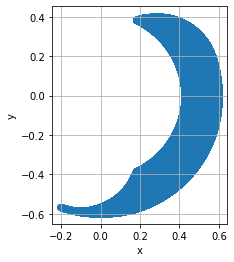

In [5]:

def plot_range():
  plt.figure(1)
  plt.scatter(din[:,0], din[:,1])
  plt.xlabel('x')
  plt.ylabel('y')
  #plt.xlim(0,2.5)
  plt.grid(True)
  plt.gca().set_aspect("equal")


plot_range()

# NN

Zwei Fully Connected Layer.

Als Fehlerfunktion wird der quadratische Fehler genutzt. Sie können auch [andere Loss Functions](https://keras.io/api/losses/) ausprobieren.

Testen Sie auch verschiedene [Optimizer](https://keras.io/api/optimizers/).

Testen Sie auch alternative Anzahlen von Layern und Layergrößen.

## Netzwerkmodell

In [6]:
# Netzwerkparameter

layer1size = 30
layer2size = 20



In [7]:
mymodel = keras.Sequential([
      layers.Dense(layer1size, input_shape=[2,], activation='tanh'), ## Input Layer
      layers.Dense(layer2size, activation='tanh'),
      layers.Dense(2)     ## output
  ])

mymodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                90        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 42        
Total params: 752
Trainable params: 752
Non-trainable params: 0
_________________________________________________________________


## Alternative eigendefinierte Loss Funktionen

In [ ]:
# Standard Mean Squared Error Loss
mseloss = tf.keras.losses.MeanSquaredError()

# Alternative eigendefinierte Loss Funktionen

# myloss1: berücksichtigt den quadratischen Fehler 
# in den Koordinaten, nicht in den Winkeln
# y_true sind die Winkel-Label, y_pred die berechneten Winkel
# in_true sind die x-y label, in_pred die berechneten x-y Koordinaten.

def myloss1(y_true,y_pred):

  in_true = forward_kinematics(y_true)
  in_pred = forward_kinematics(y_pred)

  return kb.mean(kb.square(in_true - in_pred))

# myloss2: myloss1 mit Regularisierungsterm
# Die Abbildung von x-y koordinaten auf Winkel ist nicht eindeutig

def myloss2(y_true,y_pred):

  in_true = forward_kinematics(y_true)
  in_pred = forward_kinematics(y_pred)

  return kb.mean(kb.square(in_true - in_pred) + 0.01* kb.square(y_true - y_pred))


## Trainingsparameter

In [ ]:
# Trainingsparameter

learning_rate = 0.01
batch_size = 50
epochs = 10
myloss = losses.mean_squared_error
#myloss = myloss1
#myloss = myloss2

myoptimizer = optimizers.SGD  #
#myoptimizer = optimizers.Adam  #


In [ ]:
 mymodel.compile(loss=myloss,
                optimizer=myoptimizer(learning_rate=learning_rate))

## Trainiere Modell

Nutze 20% der Testdaten als Validierungsdatensatz

In [ ]:
history = mymodel.fit(din, dout,
          batch_size=batch_size, epochs=epochs,
          validation_split = 0.2)

In [ ]:


def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

## Teste trainiertes Modell

In [ ]:
testdatasize = 10000

(testdata_in, testdata_out) = gen_data(testdatasize)

print(testdata_in.shape)

predictions = mymodel.predict(testdata_in)

somedata = np.random.choice(predictions.shape[0], 5)

for d in somedata:
  print(predictions[d]*180/np.pi, testdata_out[d]*180/np.pi)

tf.print(forward_kinematics(predictions[somedata]))

tf.print(forward_kinematics(testdata_out[somedata]))

error = mymodel.evaluate(testdata_in, testdata_out, verbose=0)
print(error)

## Teste verschiedene Trajektorien

### Hilfsfunktionen

In [ ]:
# Gerade

def gerade(x1, y1, x2, y2):
  t = np.linspace(0,1)
  x = x1 + t*(x2-x1)
  y = y1 + t*(y2-y1)

  return (x, y)


def kreis(x0, y0, R):
  t = np.linspace(0, 2*np.pi)
  x = x0 + R*np.sin(t)
  y = y0 + R*np.cos(t)

  return (x,y)

def parabelbogen(x1,y1,x2,y2):
  t = np.linspace(0,1)
  x = x1 + (x2-x1) * t
  y = y1 + (y2-y1) * t*t 

  return (x,y)

def plot_trajectory(t, figure=100, zoom=True):
  (x, y) = t
  plt.figure(figure)
  plt.plot(x,y, label='soll')
  phipred = mymodel.predict(np.vstack((x, y)).T)

  # Berechne x und y
  xpred = l1 * np.cos(phipred[:,0]) + l2 * np.cos(phipred.sum(axis=1))
  ypred = l1 * np.sin(phipred[:,0]) + l2 * np.sin(phipred.sum(axis=1))

  pred = forward_kinematics(mymodel.predict(np.vstack((x, y)).T))

  plt.plot(pred[:,0], pred[:,1], label='ist')
  plt.grid(True)
  plt.legend()
  plt.gca().set_aspect("equal")
  dx = np.max(x) - np.min(x)
  dy = np.max(y) - np.min(y)
  if zoom:
    plt.xlim(np.min(x)-0.1*dx, np.max(x)+0.1*dx)
    plt.ylim(np.min(y)-0.1*dy, np.max(y)+0.1*dy)
  else: 
    plt.xlim(-0.2, 0.6)
    plt.ylim(-0.6, 0.4) 





### Plot

In [ ]:
# Alle in einen Plot
plot_trajectory(gerade(0.4,-0.2, 0.5, -0.2), zoom=False)
plot_trajectory(kreis(0.5, 0.1, 0.05), zoom=False)
plot_trajectory(parabelbogen(0.2,-0.5, 0.5, 0.2), zoom=False)


# Einzelplots gezoomt
plot_trajectory(gerade(0.4,-0.2, 0.5, -0.2), figure=2)
plot_trajectory(kreis(0.5, 0.1, 0.05), figure=3)
plot_trajectory(parabelbogen(0.2,-0.5, 0.5, 0.2), figure=4)
